In [ ]:
!pip install datasets

In [ ]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, TrainingArguments, Trainer
import torch
from datasets import Dataset
import pandas as pd

In [ ]:
# Loading dataset

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/complaints.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)
df.head()

,product,narrative
0,credit_card,purchase order day shipping amount receive pro...
1,credit_card,forwarded message date tue subject please inve...
2,retail_banking,forwarded message cc sent friday pdt subject f...
3,credit_reporting,payment history missing credit report speciali...
4,credit_reporting,payment history missing credit report made mis...


In [ ]:
df.info()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162421 entries, 0 to 162420
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   product    162421 non-null  object
 1   narrative  162411 non-null  object
dtypes: object(2)
memory usage: 2.5+ MB


,0
product,0
narrative,10


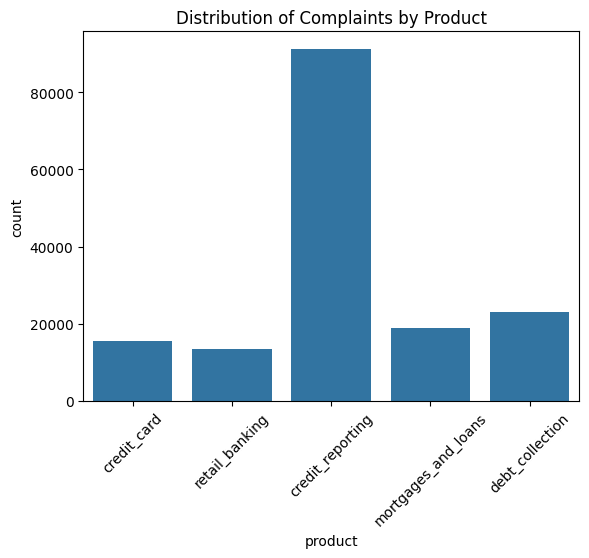

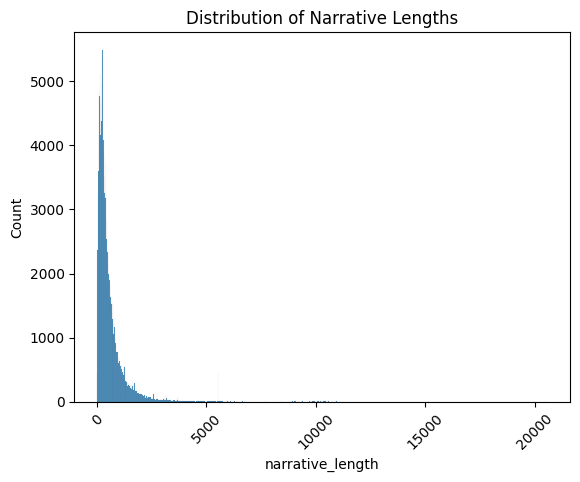

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x='product', data=df)
plt.title('Distribution of Complaints by Product')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.show()

# Histogram of narrative lengths, handling NaN values
df['narrative_length'] = df['narrative'].apply(lambda x: len(str(x)) if pd.notnull(x) else 0)
sns.histplot(df['narrative_length'])
plt.title('Distribution of Narrative Lengths')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.show()

In [ ]:
df_sample = df.dropna(subset=["narrative"]).sample(500, random_state=42)

In [ ]:
# We will divide complaints into 4 classes
query_types = {
    "retail_banking": 0,              # Account Inquiry
    "credit_reporting": 1,            # Service Complaint
    "credit_card": 2,                 # Transaction Issue
    "mortgages_and_loans": 2,         # Transaction Issue
    "debt_collection": 3              # Fraud Report
}

# Appling mapping
df_sample["label"] = df_sample["product"].map(query_types)

# Selecting text and label
data = df_sample[["narrative", "label"]].rename(columns={"narrative": "text"})

# Verifying distribution
print("Label distribution:")
data["label"].value_counts()

Label distribution:


,count
label,
1,288
2,105
3,62
0,45


In [ ]:
dataset = Dataset.from_pandas(data)
dataset = dataset.train_test_split(test_size=0.2)
train_dataset = dataset['train']
test_dataset = dataset['test']

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=32)  # Reduced for speed

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)
train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

print("Train sample example:", train_dataset[0])

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Train sample example: {'label': tensor(0), 'input_ids': tensor([  101,  4156,  8592,  3604,  8592, 13261,  2349,  2231,  8636,  8354,
         8592,  2240,  2240,  9449, 13995, 25416,  8630,  2139, 16313,  4003,
        25416,  8630,  5827,  2924,  4070, 11925,  2924,  3103, 24669,  6406,
         7593,   102]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])}


In [ ]:
# Training the model
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=4)

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=5,
    per_device_train_batch_size=5,  # Reduced for stability
    per_device_eval_batch_size=5,
    warmup_steps=12,  # Reduced for small dataset
    weight_decay=0.01,
    logging_steps=2,  # More frequent updates
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=lambda p: {"accuracy": (p.predictions.argmax(-1) == p.label_ids).mean()}
)

trainer.train()
results = trainer.evaluate()
print("Evaluation results:", results)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.601300,0.679984,0.770000
2,1.160300,0.630845,0.780000
3,0.581100,0.547925,0.780000
4,0.503700,0.514490,0.820000
5,0.031200,0.533670,0.840000


Evaluation results: {'eval_loss': 0.5144898891448975, 'eval_accuracy': 0.82, 'eval_runtime': 0.209, 'eval_samples_per_second': 478.496, 'eval_steps_per_second': 95.699, 'epoch': 5.0}


## Final accuracy is 82% with sample size of only 500 samples and 5 epochs (random accuracy would be ~25%).
To obtain better results we could:
* Increase sample size or use the whole dataset (would take a lot of resources and take time)
* Increase the number of epochs
* Change batch sizes
* Change the number of warmup steps

# Let's build a confusion matrix for some visuals

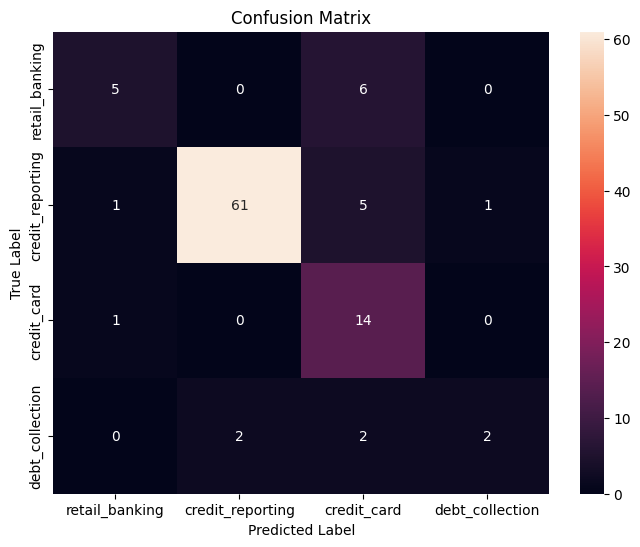

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

predictions = trainer.predict(test_dataset)
pred_labels = np.argmax(predictions.predictions, axis=-1)
true_labels = predictions.label_ids

cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(8, 6))
labels = ['retail_banking', 'credit_reporting', 'credit_card', 'debt_collection']
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

### Here let's check on our own examples

In [ ]:
labels = ["Account Inquiry", "Service Complaint", "Transaction Issue", "Fraud Report"]
test_texts = [
    "How do I check my savings balance?",
    "Your app keeps crashing!",
    "My credit card payment didn’t go through.",
    "Someone charged $500 on my account!"
]

for text in test_texts:
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=32)
    inputs = inputs.to(model.device)
    outputs = model(**inputs)
    prediction = outputs.logits.argmax().item()
    print(f"Text: '{text}' -> {labels[prediction]}")

Text: 'How do I check my savings balance?' -> Transaction Issue
Text: 'Your app keeps crashing!' -> Service Complaint
Text: 'My credit card payment didn’t go through.' -> Transaction Issue
Text: 'Someone charged $500 on my account!' -> Account Inquiry


In [ ]:
# Generating a report
from datetime import datetime

# Function to generate a report
def generate_report(df, accuracy_before_tuning, accuracy_after_tuning, misclassified_samples_before, misclassified_samples_after):
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    report_filename = f"complaints_report_{timestamp}.txt"

    with open(report_filename, 'w') as report_file:
        report_file.write("Complaints Resolution Report\n")
        report_file.write(f"Generated on: {timestamp}\n\n")

        # Add findings, insights, and recommendations
        report_file.write("Findings and Insights:\n")
        report_file.write(f" - Before hyperparameter tuning, the model accuracy was {accuracy_before_tuning:.2%}.\n")
        report_file.write(f" - After hyperparameter tuning, the model accuracy improved to {accuracy_after_tuning:.2%}.\n")
        report_file.write(f" - The error analysis showed {misclassified_samples_before} misclassified samples before tuning and {misclassified_samples_after} after tuning.\n")
        report_file.write(" - Recommendations: Use Bag of Words (BOW) with the best hyperparameters for optimal performance.\n\n")

    print(f"Report generated successfully: {report_filename}")
accuracy_before_tuning = ///
accuracy_after_tuning = ///
misclassified_samples_before = ///
misclassified_samples_after = ///

generate_report(df, accuracy_before_tuning, accuracy_after_tuning, misclassified_samples_before, misclassified_samples_after)

In [ ]:
# Saving the model
import joblib
joblib.dump(best_model, 'best_model.pkl')